# PSF exploration in DP0.2 images

version: Weekly 2023_47 <br>
Container Size: medium 

**Description:** In this notebook we explore the properties of the PSF model from DP0.2 images. First we show how to extract the PSF model from DP0.2 single exposures (calexp) and coaded images (deepCoadd) using the method `getPsf()` from the `Exposure` class, as well as querying both the src and object tables, respectively. Then we explore the diferences between the PSF model and the actual measurements of the source, and plot residual distributions. Finally, we explore the variability of PSF size and shape across the whole visit and in coadded regions of ~1deg$^2$ and its dependence on the observing wavelength.

**Contributor:** K.A. Alamo-Martinez

---
# Set up

In [1]:
### Rubin-specific packages
from lsst.daf.butler import Butler
import lsst.geom as geom
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')
from lsst.rsp import get_tap_service
service = get_tap_service("tap")
assert service.baseurl == "https://data.lsst.cloud/api/tap"

### General python / astronomy packages
import math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord

# To ignore some kinds of warnings
import warnings
warnings.filterwarnings('ignore')

---

# 1. PSF model extraction from DP0.2 images

In astrophysics, the most used measurement to define the quality of an image is the width of the Point Spread Function (PSF). The PSF is a function that describes the surface brightness profile of point sources, and encloses information from the instrument optics and atmospheric conditions. 

Currently, the standard method to model the PSF within the LSST pipelines uses a modified version of the public [PSFEx](https://psfex.readthedocs.io/en/latest/Working.html) (Point Spread Function Extractor) code where the modification is on the point source selection, using K-means clustering classification instead of a selection based on radius and magnitude (module [lsst.meas.extensions.psfex](https://pipelines.lsst.io/modules/lsst.meas.extensions.psfex/index.html)) .

## 1.1 Using the method `getPsf()` from the `Exposure` class 


In [2]:
# Instantiate the butler to have acces to DPO.2 data

repo = 'dp02'
collection = '2.2i/runs/DP0.2'
butler = Butler(repo, collections=collection)

### 1.1.1 PSF extraction from a calexp

Since the PSF variates across the image, we have to give the coordinates (central position in pixels) from where we want to retrieve the PSF. In this example the coordinates are (100,100). If there's no point given, it returns the PSF for central point in the calexp.

In [3]:
## data ID for a calexp. There's no need to specify the band.

dataId = {'visit': '400357', 'detector': 43}
calexp = butler.get('calexp', dataId=dataId)

The trace radius of the covariance matrix of the 2nd moments of the light, gives the standard deviation ($\sigma$) of the light distribution. Along the notebook it is used as an estimate for the size of the PSF. 
For a Gaussian distribution, the Full Width at Half Maximum (FWHM) is ~ $\sigma$/1.18


In [4]:
point = geom.PointD(100.,100.)

# Extraction of PSF information
psf = calexp.getPsf()

# Compute the trace radius at the given point
TraceRadius = psf.computeShape(point).getTraceRadius() 
print('TraceRadius [pix] = ', TraceRadius)

TraceRadius [pix] =  2.1957047535175254


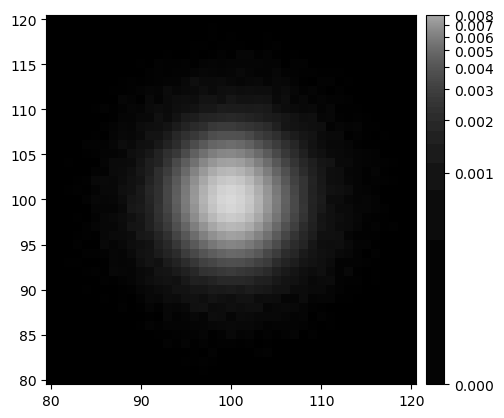

In [5]:

# Extracts an array of flux at each pixel
psfimage = psf.computeImage(point)

# one way to display images (the prefered)
display = afwDisplay.Display()
display.scale('asinh', min=0.0, max=1.e-3, unit='absolute')
display.mtv(psfimage)

#### PSF comparison for two different coodinates 

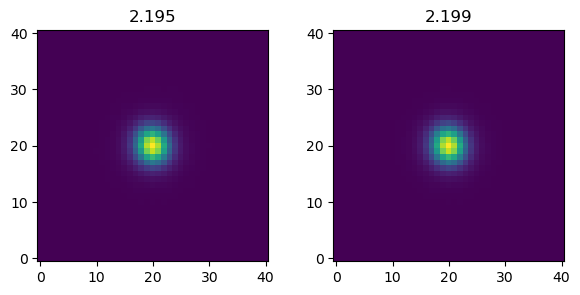

In [6]:
point1 = geom.PointD(10.,10.)
point2 = geom.PointD(20.,400.)

psfimage1 = psf.computeImage(point1)
psfimage2 = psf.computeImage(point2)

psf_size1 = np.round(psf.computeShape(point1).getTraceRadius(),3)
psf_size2 = np.round(psf.computeShape(point2).getTraceRadius(),3)

# another way to display images
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
ax[0].set_title(psf_size1)
ax[0].imshow(psfimage1.getArray(), origin='lower')

ax[1].set_title(psf_size2)
ax[1].imshow(psfimage2.getArray(), origin='lower');


### 1.1.2 PSF extraction from a deepCoadd

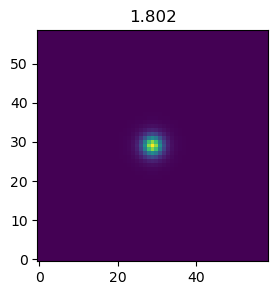

In [7]:
## data ID for a coadd. Note that here the band has to be specified
dataId = {'tract': 3831, 'patch': 3, 'band': 'r'}
coadd = butler.get('deepCoadd', **dataId)

psf_coadd = coadd.getPsf()
point = geom.PointD(13000., 500.)
psf_size_coadd = np.round(psf_coadd.computeShape(point).getTraceRadius(), 3)
psfimage_coadd = psf_coadd.computeImage(point)

fig, ax = plt.subplots( figsize=(7, 3))
ax.set_title(psf_size_coadd)
ax.imshow(psfimage_coadd.getArray(), origin='lower');


---

## 1.2 Querying PSF information from source/object tables

Working with catalogs could more efficient than manipulating images. In this section we will retrive the moments of the light distribution to then calculate the determinant radius.  

The recomended way to extract catalog data is the Table Access Protocol (TAP) service but it is also possible to access through the butler. 

The structure of the catalogs (column names, data type and description) can be seen in the [DPO2 schemas webpage](https://dm.lsst.org/sdm_schemas/browser/dp02.html).

In [8]:
# function to calculate the size and ellipticity using the intensity moments

def PSF_shape(i_xx, i_yy, i_xy):
    ''' function to calculate the size and elipticity
    using the light moments. The output radius is in pixels'''
    theta = np.arctan2(2. * i_xy, i_xx - i_yy) / 2.
    e1 = (i_xx - i_yy) / (i_xx + i_yy)
    e2 = (2. * i_xy) / (i_xx + i_yy)
    e = np.sqrt(e1**2 + e2**2)
    TraceRad = np.sqrt((i_xx + i_yy) / 2.)
    DetRad = (i_xx * i_yy - i_xy**2)**(1. / 4.)
    return TraceRad, DetRad, e, e1, e2


### 1.2.1  Accesing the catalog through the butler

###   src catalog (calexp sources)

The catalog of objects detected in a single calbrated exposure (claexp) is called **src** catalog. To acces a src catalog we have to indicate the id of the calexp from which the catalog was constructed. 
From the src catalog we select the sources used to construct the PSF model and get the moments (Ixx, Iyy, Ixy). 

In [9]:
dataId = {'visit': '400357', 'detector': 43}
src = butler.get('src', **dataId)

# point sources used to model the PSF:
psf_used = src[src['calib_psf_used'] == True] 

# point sources reserved to test the PSF model:
psf_reserved = src[src['calib_psf_reserved'] == True]

i_xx_psf_used = psf_used['base_SdssShape_psf_xx']
i_yy_psf_used = psf_used['base_SdssShape_psf_yy']
i_xy_psf_used = psf_used['base_SdssShape_psf_xy']

###  object catalog (deepCoadd sources)

The catalog of sources contructed form a deepCoadd is called objectTable, and we have to give the id of the deepCoadd. 

The catalog of objects detected in a deepCoadd image is called **object** catalog. To acces an object catalog we have to indicate the id of the coadd from which the catalog was constructed. 
From the object catalog we select all the point sources (Extendedness = 0) to the extract the moments (Ixx, Iyy, Ixy). 

In [10]:
dataId = {'tract': 3831, 'patch': 3, 'band': 'r'}
obj = butler.get('objectTable', **dataId)

# point sources:
point_sources = obj[obj['refExtendedness'] == 0]

i_xx_point = point_sources['r_ixxPSF']
i_yy_point = point_sources['r_iyyPSF']
i_xy_point = point_sources['r_ixyPSF']

### 1.2.3  Accesing through the TAP service

### src catalog (calexp sources)

SQL request for the sources used to construct the PSF (calib_psf_used = True) in a given visit. 

In [11]:

visitId = 1221264

query_visit = "SELECT TOP 5 coord_ra, coord_dec, ixx, ixxPSF, ixy, ixyPSF, iyy, iyyPSF " + \
        "FROM dp02_dc2_catalogs.Source WHERE visit = " + str(1221264) + \
        " AND calib_psf_used != 0"

results_visit = service.search(query_visit).to_table().to_pandas()

In [12]:
results_visit

coord_ra  coord_dec       ixx    ixxPSF       ixy    ixyPSF       iyy  \
0  50.567358 -44.520680  3.930651  3.971403 -0.047860 -0.035829  4.357280   
1  50.448426 -44.507011  4.000373  3.998172 -0.149302 -0.070759  4.393096   
2  50.609403 -44.680790  3.956506  3.944896 -0.172590 -0.055706  4.494814   
3  50.481580 -44.533328  4.026574  4.008239 -0.005329 -0.084712  4.352842   
4  50.644897 -44.591134  4.028266  3.937001 -0.150578 -0.052099  4.080455   

     iyyPSF  
0  4.332845  
1  4.308715  
2  4.300218  
3  4.279441  
4  4.307057

###  object catalog (deepCoadd sources)

SQL request for all the point sources from the object catalog within a circular region with given coordinates and radius. 

In [21]:
ra_deg = 55.745834
dec_deg = -32.269167

point_sky = SkyCoord(ra = ra_deg*u.degree, dec = dec_deg*u.degree, frame='icrs')
radius = 0.01 * u.deg

# Here we select the moment for the g band but the Object table has information for all the bands. 
query_coadd = " SELECT coord_ra, coord_dec, g_ixxPSF, " + \
        "g_ixyPSF, g_ixy, " + \
        "g_iyyPSF, g_iyy " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec),CIRCLE('ICRS', " + \
        str(point_sky.ra.value) + ", " + str(point_sky.dec.value) + ", " + \
        str(radius.value) + " )) = 1 " + \
        "AND refExtendedness = 0"

results_coadd = service.search(query_coadd).to_table().to_pandas()

In [14]:
results_coadd.head()

coord_ra  coord_dec  g_ixxPSF  g_ixyPSF     g_ixy  g_iyyPSF     g_iyy
0  55.745536 -32.260319  3.682618 -0.020836  0.128584  3.421508  4.723568
1  55.746201 -32.266441  3.546288 -0.027569  0.181359  3.294981  3.217543
2  55.744957 -32.276487  3.670871 -0.025466  0.037354  3.407527  3.184802
3  55.741206 -32.272494  3.712636 -0.022584 -0.307749  3.448378  3.014156
4  55.744167 -32.277434  3.642053 -0.024499  0.346316  3.384392  3.378127

---

# 2. Diferences between PSF model and the actual measurements of the source.

### 2.1.1 PSF size and ellipticity comparison in a single calexp

In [15]:
def PSF_diagnostics(visit, detector, band): 
    # calexp information to access the src catalog
    dataId={'band': band, 'visit': visit, 'detector': detector}  
    calexp = butler.get('calexp', **dataId)
    src = butler.get('src', **dataId)
    psf = calexp.getPsf()

    # grid definition
    x_array = np.arange(0, calexp.getDimensions()[0]+1, 200)
    y_array = np.arange(0, calexp.getDimensions()[1]+1, 200)
    xx, yy = np.meshgrid(x_array, y_array)

    size = [] # trace radius
    det_radius = []
    i_xx, i_yy, i_xy = [] , [] , []
    for x, y in zip(xx.flatten(), yy.flatten()):
        point = geom.Point2D(x, y)
        shape = psf.computeShape(point)
        size.append(shape.getTraceRadius())
        det_radius.append(shape.getDeterminantRadius()) 
        i_xx.append(shape.getIxx())
        i_yy.append(shape.getIyy())
        i_xy.append(shape.getIxy())
    size = np.reshape(size, xx.shape)
    i_xx = np.reshape(i_xx, xx.shape)
    i_yy = np.reshape(i_yy, xx.shape)
    i_xy = np.reshape(i_xy, xx.shape)
    det_radius = np.reshape(det_radius, xx.shape)
    dif_rad = np.abs(size - det_radius)

    e1 = (i_xx - i_yy) / (i_xx + i_yy)
    e2 = (2. * i_xy) / (i_xx + i_yy)
    e = np.sqrt(e1**2 + e2**2)
    theta = np.arctan2(2. * i_xy, i_xx - i_yy) / 2.
    # for the sticks plot
    ex = e * np.cos(theta)
    ey = e * np.sin(theta)
        
    def comparison_src_psf(sample):
        output = []
        for i in range(len(sample)):
            point = sample[i].getCentroid()
            shape_psf = psf.computeShape(point)
            i_xx_psf = sample[i]['base_SdssShape_psf_xx']
            i_yy_psf = sample[i]['base_SdssShape_psf_yy']
            i_xy_psf = sample[i]['base_SdssShape_psf_xy']
            TraceRad_psf, DetRad_psf, e_psf, e1_psf, e2_psf = PSF_shape(i_xx_psf, i_yy_psf, i_xy_psf)

            i_xx_src = sample[i]['base_SdssShape_xx']
            i_yy_src = sample[i]['base_SdssShape_yy']
            i_xy_src = sample[i]['base_SdssShape_xy']
            e_src = PSF_shape(i_xx_src, i_yy_src, i_xy_src)[2]
            TraceRad_src , DetRad_src , e_psf, e1_psf, e2_psf= PSF_shape(i_xx_src, i_yy_src, i_xy_src)
            x_point = point[0]
            y_point = point[1]
            mag = -2.5*np.log10(sample[i]['base_CircularApertureFlux_17_0_instFlux'])
            output.append([x_point, y_point, TraceRad_psf, DetRad_psf, e_psf, TraceRad_src, DetRad_src, e_src, mag])

        return np.asarray(output)

    # to include a magnitud constrain:
    #psf_used = src[(src['calib_psf_used'] == True) & (-2.5*np.log10(src['base_CircularApertureFlux_17_0_instFlux']) > -13)]
    #psf_reserved = src[(src['calib_psf_reserved'] == True) & (-2.5*np.log10(src['base_CircularApertureFlux_17_0_instFlux']) > -13)]

    psf_used = src[src['calib_psf_used'] == True]
    psf_reserved = src[src['calib_psf_reserved'] == True]
    
    used = comparison_src_psf(psf_used)
    reserved = comparison_src_psf(psf_reserved)

    fig, ax = plt.subplots(2, 2, figsize=(12, 10))

    #############  CALEXP  #############
    plt.sca(ax[0,0])  
    display1 = afwDisplay.Display(frame=fig)
    display1.scale('linear', 'zscale')
    display1.mtv(calexp.image)
    display1.show_colorbar(False)
    plt.text(150, 150, band +" band", color = 'y', fontsize=20)
    plt.text(150, 3700, "visit "+ str(visit) + "   detector " + str(detector), color = 'orange', fontsize=18)
    for s in psf_used:
        plt.plot(s.getX(), s.getY(), 'o', ms=6, mew=1.5, mfc = 'None', mec = 'b')

    #############  TRACE RADIUS  #############
    plt.sca(ax[0,1])
    plt.pcolormesh(xx, yy, size, vmin=np.min(size), vmax=np.max(size), cmap='cool', shading='auto')
    colorbar = plt.colorbar(label='Trace Radius [pix]')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Size')

    x_used = used[:,0]
    y_used = used[:,1]
    TraceRad_used = used[:,5]
    plt.rcParams['scatter.edgecolors'] = "k"
    marker_size_mag = np.abs(used[:,8]**4)*0.001
    plt.scatter(x_used, y_used, c=TraceRad_used, s = marker_size_mag, vmin=np.min(size), vmax=np.max(size), cmap='cool')

    #############  ELLIPTICITY STICKS  #############
    plt.sca(ax[1,0])
    plt.quiver(xx, yy, ex, ey, e, headlength=0., headwidth=1., pivot='mid', width=0.01, cmap='plasma')
    colorbar = plt.colorbar(label='e')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Ellipticity Sticks')

    ############# ELLIPTICITY  #############
    plt.sca(ax[1,1])
    plt.pcolormesh(xx, yy, e, vmin=np.min(e), vmax=np.max(e), cmap='plasma', shading='auto')
    colorbar = plt.colorbar(label='e')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Ellipticity');
    e_used = used[:,7]
    plt.rcParams['scatter.edgecolors'] = "k"
    plt.scatter(x_used, y_used, c=e_used, s = marker_size_mag, vmin=np.min(e), vmax=np.max(e), cmap='plasma')


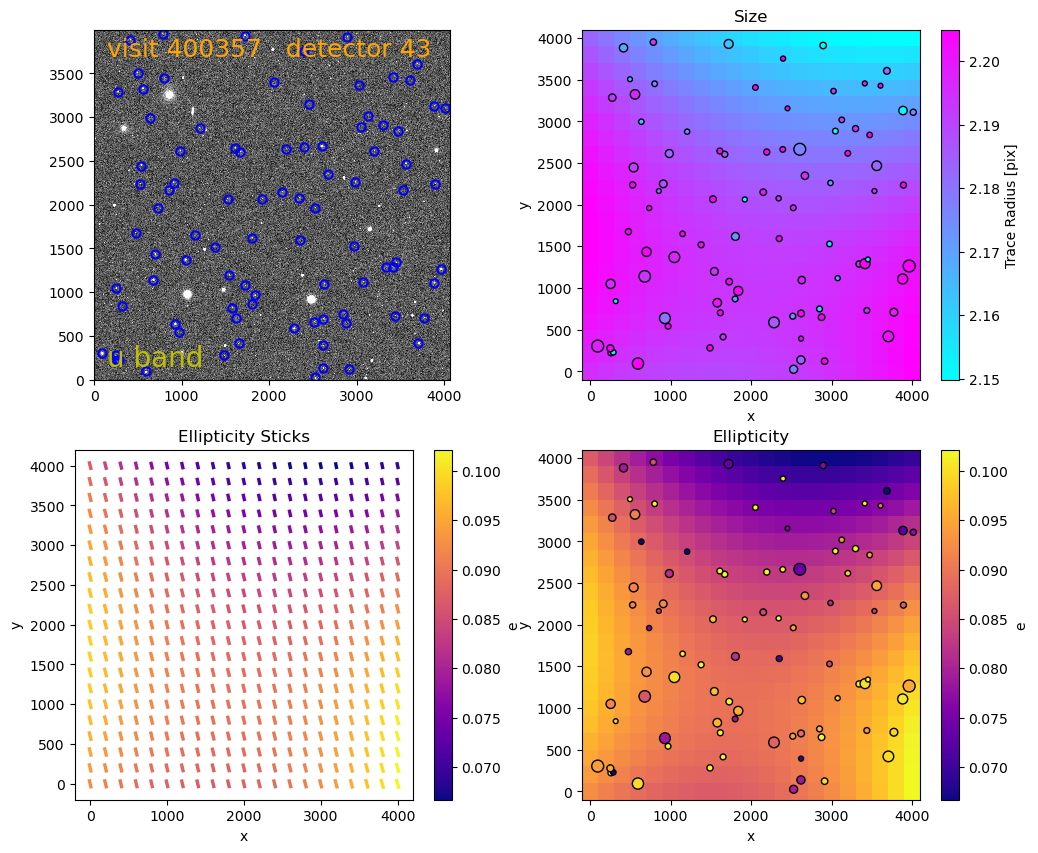

In [16]:
PSF_diagnostics(400357, 43, 'u')

### Display of the flux residuals (PSF model - star)

In [17]:
def plot_PSFresiduals(visit, detector, band):
    dataId = {'visit': visit, 'detector': detector, 'band': band}
    calexp = butler.get('calexp', dataId = dataId)
    src = butler.get('src', dataId)
    psf_used = src[src['calib_psf_used'] == True]
    psf_reserved = src[src['calib_psf_reserved'] == True]
    residuals = calexp.maskedImage.getImage()
    psf = calexp.getPsf()
    
    def plot_residuals(stars_type, ncol):
    
        if stars_type == 'reserved': 
            stars_t = psf_reserved
            title = r'Stars reserved to test PSF '
            color_title = 'lime'
        else: 
            stars_t = psf_used
            title = r'Stars used for PSF '
            color_title = 'k'

        nrow = int(len(stars_t)/ncol)
        f, ax = plt.subplots(ncols=ncol, nrows=nrow, sharex=False, sharey=False, figsize=(10, 10*(nrow/6)))

        i=0
        for r in range(nrow):
            for c in range(ncol):
                psfImage = psf.computeImage(stars_t[i].getCentroid()).convertF()
                psfImage *= stars_t[i].getPsfInstFlux()/np.sum(psfImage.getArray())
                flux = psfImage.getArray() - residuals[psfImage.getBBox()].getArray()
                ax[r,c].imshow(flux, origin='lower', cmap = 'Greys', vmin=-150, vmax=130)
                ax[r,c].set_axis_off()
                i = i + 1
        plt.title(title, color=color_title, fontsize=20, x=-1.5, y=nrow*1.04)
        plt.tight_layout()
        plt.subplots_adjust(wspace=0.01,hspace=0.01);

    plot_residuals('reserved', 6)
    plot_residuals('used', 6)


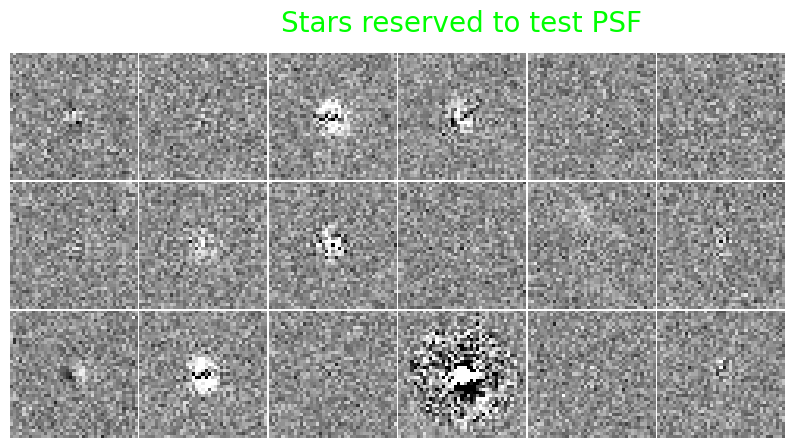

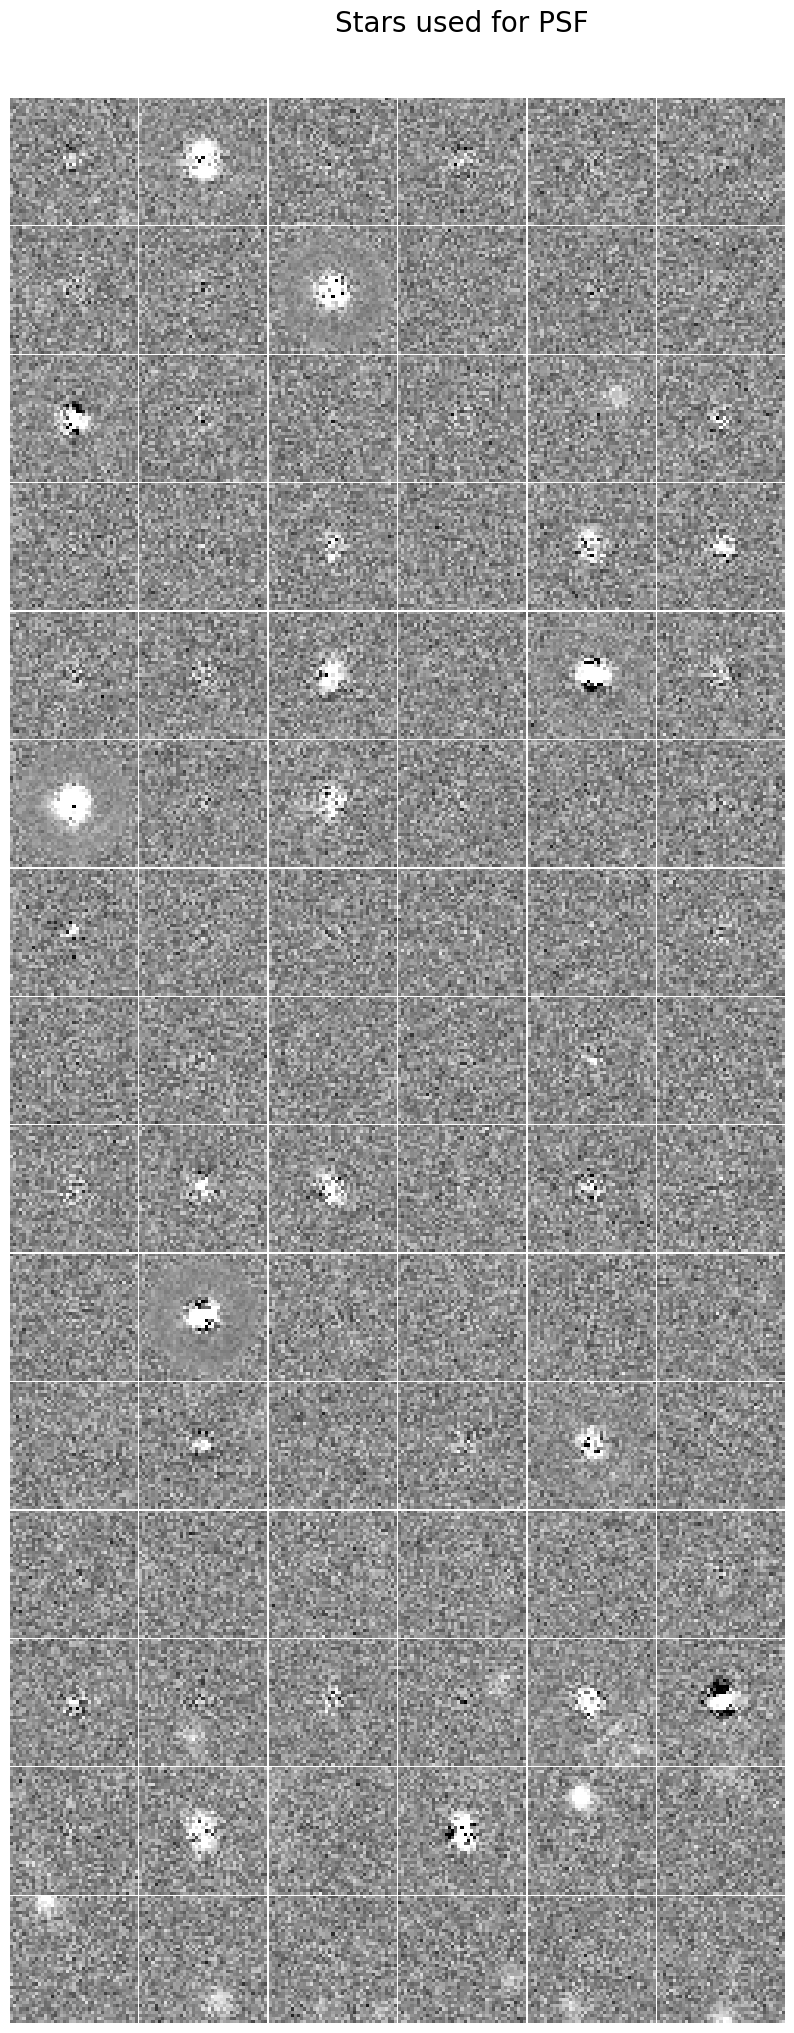

In [18]:
plot_PSFresiduals(400357, 43, 'u')

## 2.2 Distribution of PSF model minus star residuals (size and ellipticity components)

In [19]:
def PSF_star_residuals_Visit(visit,n_ccds,nbins):
    
    output = []
    for det in range(n_ccds):
        xdataId = {'band':'u','visit':visit,'detector': det} 
        ccd = butler.get('calexp', **xdataId)
        src = butler.get('src', **xdataId)
        psf_used = src[src['calib_psf_used'] == True]
        
        for i in range(len(psf_used)):
            i_xx_sdss_psf = psf_used[i]['base_SdssShape_psf_xx']
            i_yy_sdss_psf = psf_used[i]['base_SdssShape_psf_yy']
            i_xy_sdss_psf = psf_used[i]['base_SdssShape_psf_xy']
            TraceRad_psf , DetRad_psf , e_psf, e1_psf, e2_psf = PSF_shape(i_xx_sdss_psf, i_yy_sdss_psf, i_xy_sdss_psf)
            i_xx_sdss_src = psf_used[i]['base_SdssShape_xx']
            i_yy_sdss_src = psf_used[i]['base_SdssShape_yy']
            i_xy_sdss_src = psf_used[i]['base_SdssShape_xy']
            
            TraceRad_star, DetRad_star, e_star, e1_star, e2_star = PSF_shape(i_xx_sdss_src, i_yy_sdss_src, i_xy_sdss_src)
            output.append([TraceRad_psf, e_psf, e1_psf, e2_psf, TraceRad_star, e_star, e1_star, e2_star])
        
    output = np.asarray(output)
    delta_size = output[:,0] - output[:,4] #TraceRad_psf - TraceRad_star
    delta_e1 = output[:,2] - output[:,6] # e1_psf - e1_star
    delta_e2 = output[:,3] - output[:,7] #e2_psf - e2_star

    fig, ax = plt.subplots(1, 3, figsize=(11, 3))

    plt.sca(ax[0])  
    h_size = plt.hist(delta_size, nbins, color = 'b', alpha=0.4 )
    plt.xlabel(r'$\Delta_{size}$', fontsize=16)
    plt.ylabel('N')
    mean_delta_size = np.round(np.mean(delta_size),3)
    plt.axvline(x=mean_delta_size, color='k', ls='--', lw=2, alpha=0.4)
    plt.text(0.02, max(h_size[0])*0.9, str(mean_delta_size), color = 'k', fontsize=12)
    plt.xticks(ticks=[-0.04,-0.02, 0.0, 0.02, 0.04], labels=[-0.04,-0.02, 0.0, 0.02, 0.04])
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    
    plt.sca(ax[1])  
    h_e1 = plt.hist(delta_e1, nbins, color = 'b', alpha=0.4)
    plt.xlabel(r'$\Delta_{e1}$', fontsize=16)
    #plt.ylabel('N')
    mean_delta_e1 = np.round(np.mean(delta_e1),3)
    plt.axvline(x=mean_delta_e1, color='k', ls='--', lw=2, alpha=0.4)
    plt.text(0.02, max(h_e1[0])*0.9, str(mean_delta_e1), color = 'k', fontsize=12)
    plt.xticks(ticks=[-0.04,-0.02, 0.0, 0.02, 0.04], labels=[-0.04,-0.02, 0.0, 0.02, 0.04])
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    
    plt.sca(ax[2])  
    h_e2 = plt.hist(delta_e2, nbins, color = 'b', alpha=0.4)
    #print(max(h_e2[0]))
    plt.xlabel(r'$\Delta_{e2}$', fontsize=16)
    #plt.ylabel('N')
    mean_delta_e2 = np.round(np.mean(delta_e2),3)
    plt.axvline(x=mean_delta_e2, color='k', ls='--', lw=2, alpha=0.4)
    plt.text(0.02, max(h_e2[0])*0.9, str(mean_delta_e2), color = 'k', fontsize=12)

    plt.xticks(ticks=[-0.04,-0.02, 0.0, 0.02, 0.04], labels=[-0.04,-0.02, 0.0, 0.02, 0.04])
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)

    plt.subplots_adjust(wspace=0.25)


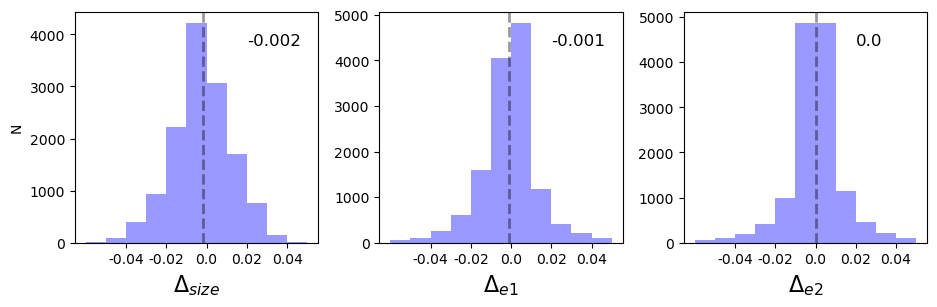

In [20]:
PSF_star_residuals_Visit(159494,189, np.arange(-0.06, 0.06, 0.01))

### Scatter plots of residuals

In [21]:
def PSF_star_residualsScatter_Visit(visit,n_ccds):
    
    output = []
    for det in range(n_ccds):
        xdataId = {'band':'u','visit':visit,'detector': det} 
        ccd = butler.get('calexp', **xdataId)
        src = butler.get('src', **xdataId)
        psf_used = src[src['calib_psf_used'] == True]
        
        for i in range(len(psf_used)):
            i_xx_sdss_psf = psf_used[i]['base_SdssShape_psf_xx']
            i_yy_sdss_psf = psf_used[i]['base_SdssShape_psf_yy']
            i_xy_sdss_psf = psf_used[i]['base_SdssShape_psf_xy']
            TraceRad_psf, DetRad_psf, e_psf, e1_psf, e2_psf = PSF_shape(i_xx_sdss_psf, i_yy_sdss_psf, i_xy_sdss_psf)
            i_xx_sdss_src = psf_used[i]['base_SdssShape_xx']
            i_yy_sdss_src = psf_used[i]['base_SdssShape_yy']
            i_xy_sdss_src = psf_used[i]['base_SdssShape_xy']
            TraceRad_star, DetRad_star, e_star, e1_star, e2_star = PSF_shape(i_xx_sdss_src, i_yy_sdss_src, i_xy_sdss_src)
            mag = -2.5*np.log10(psf_used[i]['base_CircularApertureFlux_17_0_instFlux'])
            output.append([TraceRad_psf, e_psf, e1_psf, e2_psf, TraceRad_star, e_star, e1_star, e2_star, mag])

    output = np.asarray(output)

    df = pd.DataFrame({'TraceRad_psf': output[:,0], 'e_psf': output[:,1], 'e1_psf': output[:,2], 'e2_psf': output[:,3], 'TraceRad_star': output[:,4], 'e_star': output[:,5], 'e1_star': output[:,6], 'e2_star': output[:,7], 'mag': output[:,8]})
    df['delta_size'] = df.TraceRad_psf - df.TraceRad_star 
    df['delta_e1'] = df.e1_psf - df.e1_star 
    df['delta_e2'] = df.e1_psf - df.e1_star 


    bins = np.linspace(df.mag.min(),df.mag.max(), 30)
    
    data_cut = pd.cut(df.mag,bins)           
    grp = df.groupby(by = data_cut)        
    ret = grp.aggregate(np.mean) 
    grp_mead = grp.aggregate(np.median)

    fig, ax = plt.subplots(3, 1, figsize=(8, 8))

    plt.sca(ax[0]) 
    plt.axhline(y=0, color='k', ls='--', lw=1.5, alpha=0.7)
    plt.scatter(df.mag, df.delta_size, marker='.', color = 'b', alpha=0.2)
    plt.plot(ret.mag, ret.delta_size,'r',lw=1,alpha=.7)
    plt.plot(grp_mead.mag, grp_mead.delta_size,'lime',lw=1,alpha=.7)
    #plt.scatter(mag, delta_size, marker='.', color = 'b', alpha=0.2)
    plt.ylabel(r'$\Delta_{size}$',  fontsize=20)
    plt.ylim(-0.06, 0.06)
    plt.yticks(fontsize = 14)
    plt.yticks(ticks=[-0.05, -0.025, 0.0, 0.025, 0.05], labels=[-0.05, -0.025, 0.0, 0.025, 0.05])
    
    plt.sca(ax[1])
    plt.axhline(y=0, color='k', ls='--', lw=1.5, alpha=0.7)
    plt.scatter(df.mag, df.delta_e1, marker='.', color = 'b', alpha=0.2)
    plt.plot(ret.mag, ret.delta_e1,'r',lw=1,alpha=.7)
    plt.ylabel(r'$\Delta_{e1}$',  fontsize=20)
    plt.ylim(-0.1, 0.1)
    plt.xticks(fontsize = 14)
    plt.yticks(ticks=[-0.05, 0.0, 0.05], labels=[-0.05, 0.0, 0.05])
    plt.yticks(fontsize = 14) 
    
    plt.sca(ax[2])  
    plt.axhline(y=0, color='k', ls='--', lw=1.5, alpha=0.7)
    plt.scatter(df.mag, df.delta_e2, marker='.', color = 'b', alpha=0.2)
    plt.plot(ret.mag, ret.delta_e2,'r',lw=1,alpha=.7)
    plt.ylabel(r'$\Delta_{e2}$',  fontsize=20)
    plt.xlabel('magnitude', fontsize=18)
    plt.ylim(-0.08, 0.08)
    plt.xticks(fontsize = 14)
    plt.yticks(ticks=np.arange(-0.08, 0.08, 0.04), labels=[-0.08, -0.04, 0.0, 0.04])
    plt.yticks(fontsize = 14) 
    plt.subplots_adjust(hspace=0.0)

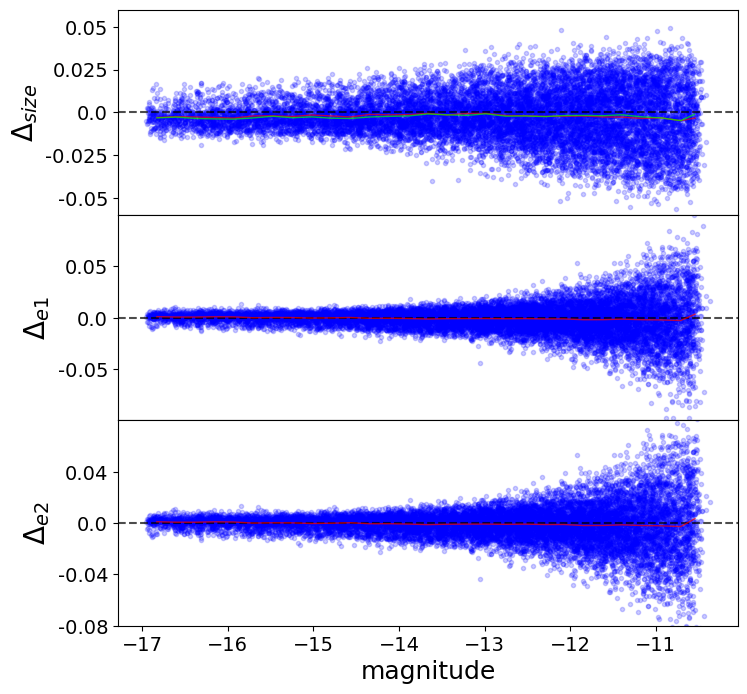

In [22]:
PSF_star_residualsScatter_Visit(159494,189)

---

# 3. PSF size and shape variability
## 3.1 Spatial variability

## 3.1.1 variability across the visit

Data extraction using the TAP service.

In [7]:
visitId = 1221264

# it doesn't work for all the registers (without the 'TOP 1000' it fails)
query_visit = "SELECT TOP 1000 coord_ra, coord_dec, ixx, ixxPSF, ixy, ixyPSF, iyy, iyyPSF " + \
        "FROM dp02_dc2_catalogs.Source WHERE visit = " + str(1221264) + \
        " AND calib_psf_used != 0"

results_visit = service.search(query_visit).to_table().to_pandas()

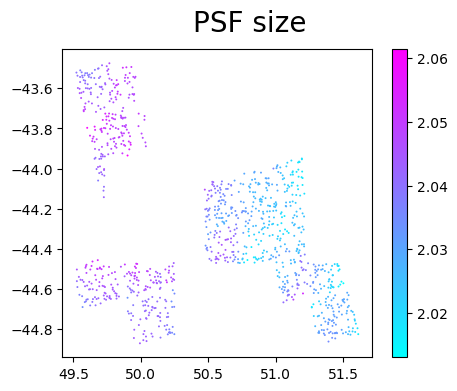

In [8]:
ra = results_visit['coord_ra']
dec = results_visit['coord_dec']

PSF_size_visit = np.sqrt((results_visit["ixxPSF"] + results_visit["iyyPSF"]) / 2.)
    

fig, ax = plt.subplots(figsize=(5, 4))
fig.suptitle("PSF size", fontsize=20)
sc = ax.scatter(ra, dec, c = PSF_size_visit, ec = None, s = 2, cmap = 'cool')
plt.colorbar(sc, ax = ax)
#plt.text(0.7, 0.93, b + " band", color = 'k', fontsize=13, transform=ax.transAxes)
    
fig.subplots_adjust(wspace=0.4)


Data extraction using the butler.

In [22]:
def fullVisit(visit, n_ccds):
    ''' this function return coordinates, psf size and ellipticity 
    for a given visit and a number of CCDs (starting in 0)'''
    
    ra, dec, psf_size, psf_ellipticity = [],[],[],[]
    
    for det in range(n_ccds):
        dataId = {'visit':visit,'detector': det} 
        src = butler.get('src', **dataId)
        point_sources = src[src['base_ClassificationExtendedness_value'] == 0.] #  in the schema is refered as 'extendedness' but returns error
    
        for i in range(len(point_sources)):
            i_xx = point_sources[i]['base_SdssShape_psf_xx'] 
            i_yy = point_sources[i]['base_SdssShape_psf_yy']
            i_xy = point_sources[i]['base_SdssShape_psf_xy']
            e1 = (i_xx - i_yy) / (i_xx + i_yy)
            e2 = (2. * i_xy) / (i_xx + i_yy)
            ra.append(point_sources[i]['coord_ra'])
            dec.append(point_sources[i]['coord_dec'])
            psf_size.append(np.sqrt((i_xx + i_yy) / 2.))
            psf_ellipticity.append(np.sqrt(e1**2 + e2**2))
         
    return np.asarray(ra), np.asarray(dec), np.asarray(psf_size), np.asarray(psf_ellipticity) 


SyntaxError: incomplete input (2793403673.py, line 2)

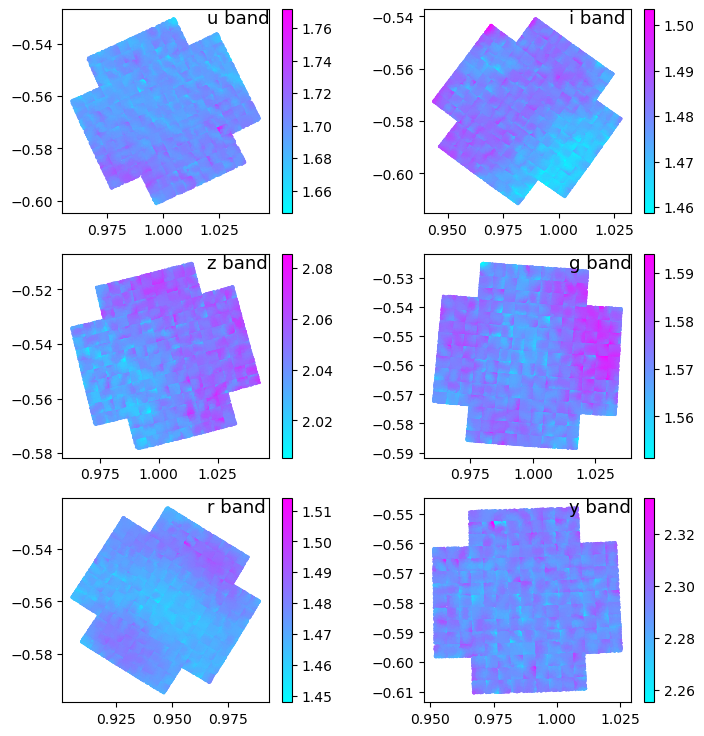

In [16]:
fig, ax = plt.subplots(3, 2, figsize=(8, 9))
fig.suptitle("PSF size", fontsize=20)
fig.subplots_adjust(wspace=0.4)

for i,v in enumerate([760255, 1169217, 908959, 951283, 648617, 1178912]):    
    dataId = {'visit':v,'detector': 0} 
    ccd = butler.get('calexp', **dataId)
    band = ccd.getFilter().bandLabel
    
    ra, dec, psf_size, psf_e = fullVisit(v,189)
    sc = ax[i%3,i%2].scatter(ra, dec, c = psf_size, s = 1, cmap = 'cool')
    plt.colorbar(sc, ax = ax[i%3,i%2])
    plt.text(0.7, 0.93, band + " band", color = 'k', fontsize=13, transform=ax[i%3,i%2].transAxes) 


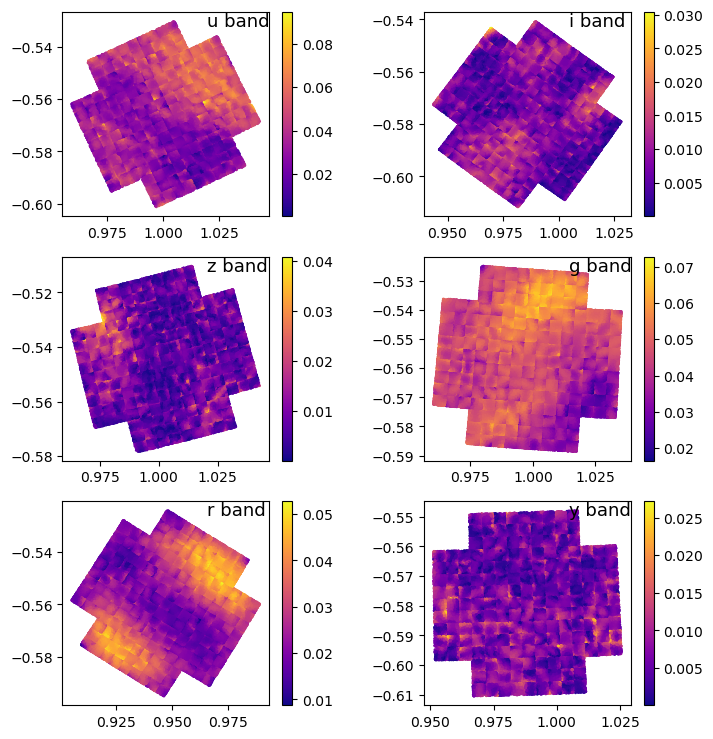

In [17]:
fig, ax = plt.subplots(3, 2, figsize=(8, 9))
fig.suptitle("PSF ellipticity", fontsize=20)
fig.subplots_adjust(wspace=0.4)

for i,v in enumerate([760255, 1169217, 908959, 951283, 648617, 1178912]):    
    dataId = {'visit':v,'detector': 0} 
    ccd = butler.get('calexp', **dataId)
    band = ccd.getFilter().bandLabel
    
    ra, dec, psf_size, psf_e = fullVisit(v,189)
    sc = ax[i%3,i%2].scatter(ra, dec, c = psf_e, s = 1, cmap = 'plasma')
    plt.colorbar(sc, ax = ax[i%3,i%2])
    plt.text(0.7, 0.93, band + " band", color = 'k', fontsize=13, transform=ax[i%3,i%2].transAxes) 


## 3.1.2 variability across a coadded region of ~1deg2

In [56]:
ra_deg = 55.745834
dec_deg = -32.269167

point_sky = SkyCoord(ra = ra_deg*u.degree, dec = dec_deg*u.degree, frame='icrs')
radius = 0.5 * u.deg

query = " SELECT objectId, coord_ra, coord_dec, u_ixxPSF, g_ixxPSF, r_ixxPSF, i_ixxPSF, z_ixxPSF, y_ixxPSF, u_ixx, g_ixx, r_ixx, i_ixx, z_ixx, y_ixx, " + \
        "u_ixyPSF, g_ixyPSF, r_ixyPSF, i_ixyPSF, z_ixyPSF, y_ixyPSF, u_ixy, g_ixy, r_ixy, i_ixy, z_ixy, y_ixy, " + \
        "u_iyyPSF, g_iyyPSF, r_iyyPSF, i_iyyPSF, z_iyyPSF, y_iyyPSF, u_iyy, g_iyy, r_iyy, i_iyy, z_iyy, y_iyy " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec),CIRCLE('ICRS', " + \
        str(point_sky.ra.value) + ", " + str(point_sky.dec.value) + ", " + \
        str(radius.value) + " )) = 1 " + \
        "AND refExtendedness = 0"

results = service.search(query).to_table().to_pandas()

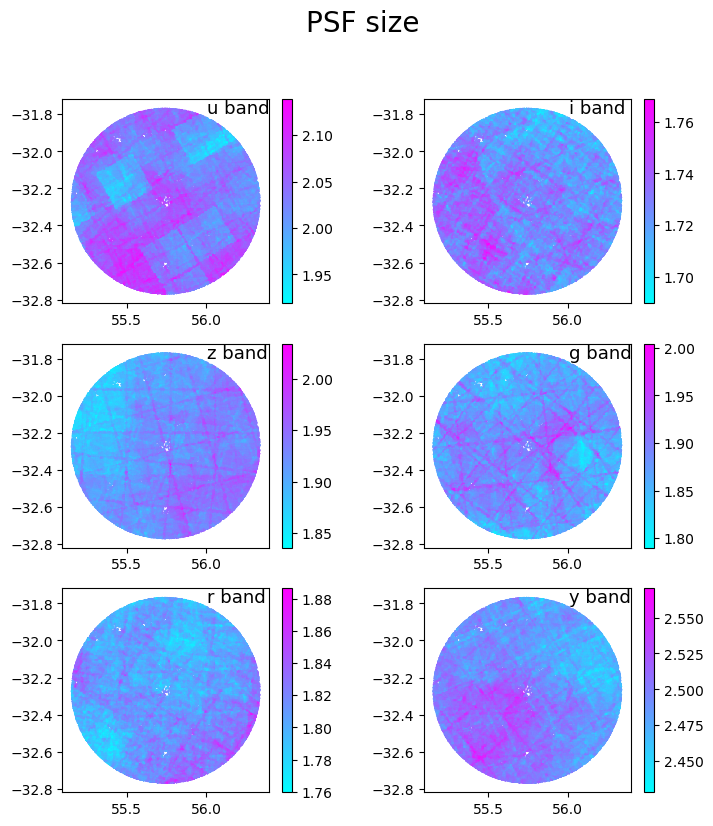

In [57]:
ra = results['coord_ra']
dec = results['coord_dec']

def PSF_size(band):
    return np.sqrt((results[band + "_ixxPSF"] + results[band + "_iyyPSF"]) / 2.)

fig, ax = plt.subplots(3, 2, figsize=(8, 9))
fig.suptitle("PSF size", fontsize=20)

for i,b in enumerate("ugrizy"):
    sc = ax[i%3,i%2].scatter(ra, dec, c = PSF_size(b), ec = None, s = 2, cmap = 'cool')
    plt.colorbar(sc, ax = ax[i%3,i%2])
    plt.text(0.7, 0.93, b + " band", color = 'k', fontsize=13, transform=ax[i%3,i%2].transAxes)
    
fig.subplots_adjust(wspace=0.4)

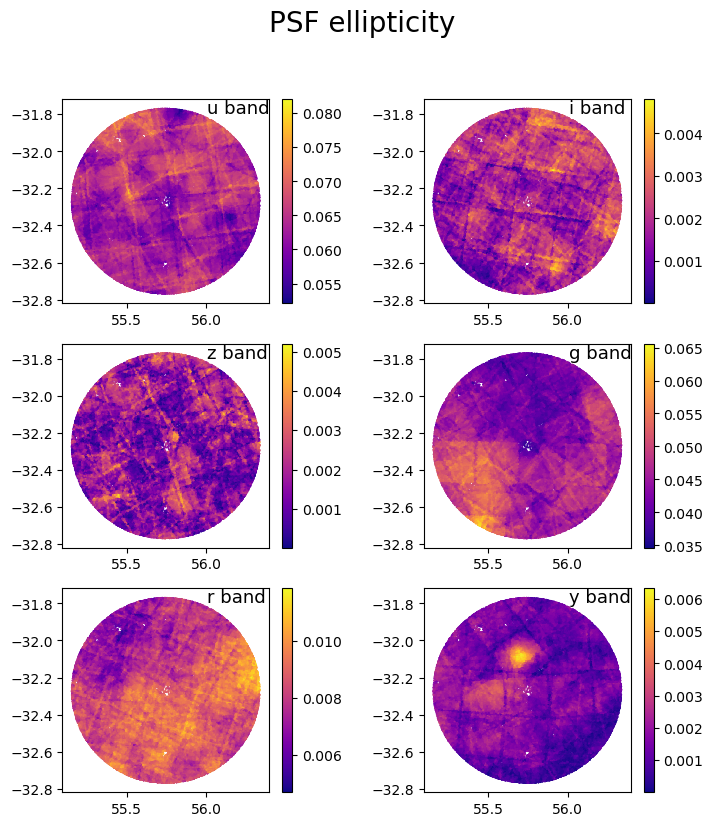

In [58]:
def ellipticity(band):
    i_xx = results[band + "_ixxPSF"]
    i_yy = results[band + "_iyyPSF"]
    i_xy = results[band + "_ixyPSF"]
    e1 = (i_xx - i_yy) / (i_xx + i_yy)
    e2 = (2. * i_xy) / (i_xx + i_yy)
    return np.sqrt(e1**2 + e2**2)

fig, ax = plt.subplots(3, 2, figsize=(8, 9))
fig.suptitle("PSF ellipticity", fontsize=20)

for i,b in enumerate("ugrizy"):
    sc = ax[i%3,i%2].scatter(ra, dec, c = ellipticity(b), ec = None, s = 2, cmap = 'plasma')
    plt.colorbar(sc, ax = ax[i%3,i%2])
    plt.text(0.7, 0.93, b + " band", color = 'k', fontsize=13, transform=ax[i%3,i%2].transAxes)
    
fig.subplots_adjust(wspace=0.4)

## 3.2 Wavelength/Filter variability

### 3.2.1 variability across the visit

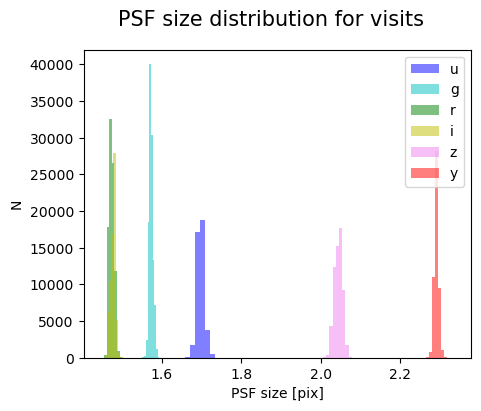

In [18]:
col = {"u": "b", "g": "c", "r": "g", "i":"y", "z":"violet", "y":"r"}

fig, ax = plt.subplots(figsize=(5, 4))
fig.suptitle("PSF size distribution for visits", fontsize=15)

for i,v in enumerate([760255, 1169217, 908959, 951283, 648617, 1178912]):
    dataId = {'visit':v,'detector': 0} 
    ccd = butler.get('calexp', **dataId)
    band = ccd.getFilter().bandLabel
    
    ra, dec, psf_size, psf_e = fullVisit(v,189)
    ax.hist(psf_size, alpha=0.5, color = col[band], label=band)

ax.set_xlabel('PSF size [pix]')
ax.set_ylabel('N')
plt.legend(loc ='upper right')

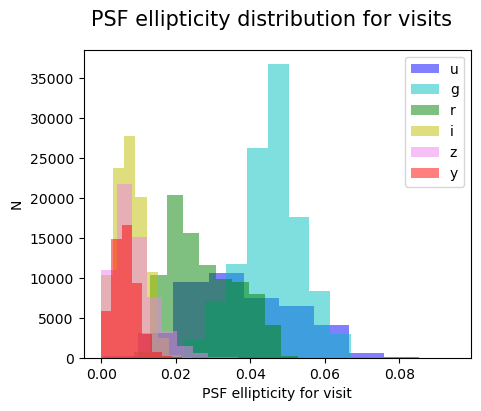

In [20]:
fig, ax = plt.subplots(figsize=(5, 4))
fig.suptitle("PSF ellipticity distribution for visits", fontsize=15 )

for i,v in enumerate([760255, 1169217, 908959, 951283, 648617, 1178912]):
    dataId = {'visit':v,'detector': 0} 
    ccd = butler.get('calexp', **dataId)
    band = ccd.getFilter().bandLabel
    
    ra, dec, psf_size, psf_e = fullVisit(v,189)
    ax.hist(psf_e, alpha=0.5, color = col[band], label=band)

ax.set_xlabel('PSF ellipticity for visit')
ax.set_ylabel('N')
plt.legend();

### 3.2.2 variability across a coadded region of ~1deg2

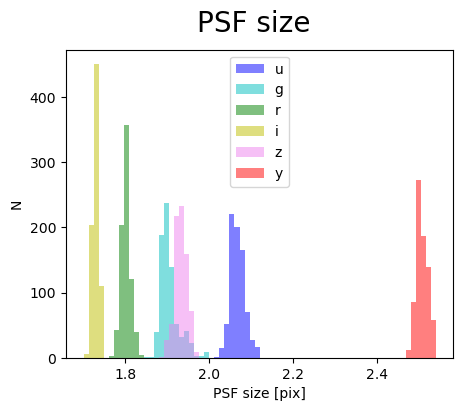

In [28]:
bins = np.arange(1.7, 2.55, 0.012)

fig, ax = plt.subplots(figsize=(5, 4))
fig.suptitle("PSF size distribution for coadded regions", fontsize=15)

col = {"u": "b", "g": "c", "r": "g", "i":"y", "z":"violet", "y":"r"}
for i,b in enumerate("ugrizy"):
    ax.hist(PSF_size(b), bins, alpha=0.5, color = col[b], label=b)

ax.set_xlabel('PSF size [pix]')
ax.set_ylabel('N')
plt.legend();

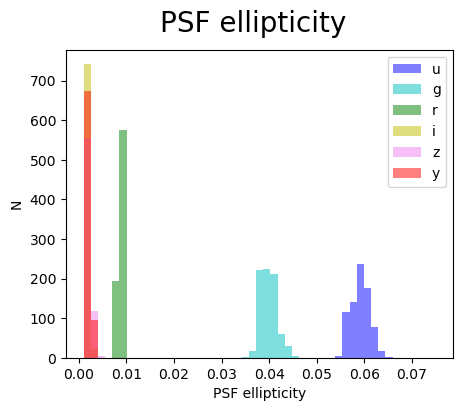

In [29]:
bins = np.linspace(0.001, 0.075, 50)

fig, ax = plt.subplots(figsize=(5, 4))
fig.suptitle("PSF ellipticity distribution for coadded regions", fontsize=15)

col = {"u": "b", "g": "c", "r": "g", "i":"y", "z":"violet", "y":"r"}
for i,b in enumerate("ugrizy"):
    ax.hist(ellipticity(b), bins, color = col[b], label=b, alpha=0.5)

ax.set_xlabel('PSF ellipticity')
ax.set_ylabel('N')
plt.legend();

---
---

## Extra material to have it in mind 

### cutout from coadd

If we need a small region from a coadded image we give central coodinates in degrees (ra_deg, dec_deg), the band and size of the region in pixels.

In [30]:
ra_deg = 62.541629
dec_deg = -37.852021
band = 'r'
size_cutout_pix = 1000

# with the sky coordinates, we identify the tract and patch that cover the desired region
point_sky = geom.SpherePoint(ra_deg, dec_deg, geom.degrees)
skymap = butler.get('skyMap')
my_tractInfo = skymap.findTract(point_sky)
my_tract = my_tractInfo.tract_id
my_patch = my_tractInfo.findPatch(point_sky).getSequentialIndex()

# read from butler the coadded image that contains the given coordinates
coaddId = {'band': band, 'tract': my_tract, 'patch': my_patch}
coadd = butler.get("deepCoadd", dataId=coaddId)

# the central coordinates in degrees are converted to pixels, to be the center of the cutout region
cutoutSize = geom.ExtentI(size_cutout_pix,size_cutout_pix) # squared region
xy = geom.PointI(my_tractInfo.getWcs().skyToPixel(point_sky))
bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)

# extraction of the desired cutout
cutout_coadd = butler.get("deepCoadd", parameters={'bbox':bbox}, dataId=coaddId)

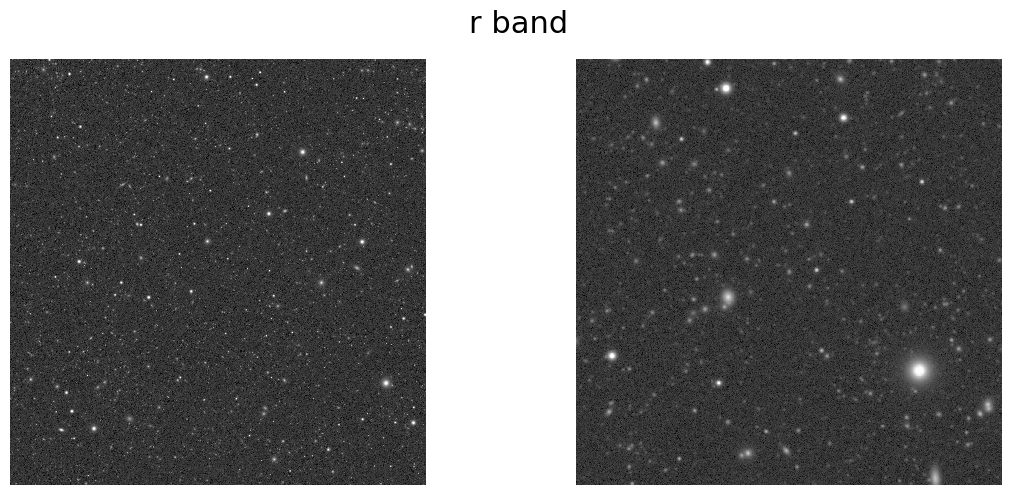

In [31]:
# display of the full coadd and the cutout region 

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(band + " band", fontsize=22)

plt.sca(ax[0])  
display1 = afwDisplay.Display(frame=fig) 
display1.scale('asinh', 'zscale')
display1.mtv(coadd.image)
display1.show_colorbar(False)
ax[0].axis('off')

plt.sca(ax[1])
display2 = afwDisplay.Display(frame=fig)
display2.scale('asinh', 'zscale')
display2.mtv(cutout_coadd.image)
display2.show_colorbar(False)

ax[1].axis('off')
plt.tight_layout()
plt.show()

---
---

## Display of CCDs and cutout region

This function plots the array of CCDs for a single visit (given as argument) and a coadded/cutout region. It is useful to visualize that a cutout can cover more than one CCD. This arrangement changes for each visit.

In [32]:
import matplotlib.patches as patches
import itertools

# https://community.lsst.org/t/visualizing-source-images-in-a-coadd/441/3
def ccdVennDiagram(exp, showImage=True, legendLocation='best', vi=0):
    '''
    Create a figure with the bounding boxes for each of the images which go into a coadd,
    over-plotting the given exposure object.
    '''
    fig = plt.figure(figsize=(8,8))
    linestyles = ['solid','dashed','dashdot','dotted']
    colors = ['b','g','r','c','m','y','k']
    pcomb = np.random.permutation(list(itertools.product(colors, linestyles)))
    # Filter out a black solid box, as that will be the style of the given exp object
    pcomb = pcomb[((pcomb[:,0] == 'k') * (pcomb[:,1] == 'solid')) == False]
    origin = geom.PointD(exp.getXY0())
    mainBox = exp.getBBox().getCorners()
    plt.gca().add_patch(patches.Rectangle((0,0),*list(mainBox[2]-mainBox[0]), fill=False, label="coadd ("+str(vi)+")"))
    ccds = exp.getInfo().getCoaddInputs().ccds
    
    i=0
    for ccd in exp.getInfo().getCoaddInputs().ccds: 
        if ccd['visit'] == vi:
            i = i+1
            ccdBox = geom.Box2D(ccd.getBBox())
            ccdCorners = ccdBox.getCorners()
            coaddCorners = [exp.getWcs().skyToPixel(ccd.getWcs().pixelToSky(point)) + \
                        (geom.PointD() - origin) for point in ccdCorners]


            plt.gca().add_patch(patches.Polygon(coaddCorners, fill=False, color=pcomb[i][0], ls=pcomb[i][1], label="CCD{}".format(ccd['ccd'])))
    if showImage:
        plt.imshow(exp.image.getArray(), cmap='Greys', origin='lower')

    plt.gca().relim()
    plt.gca().autoscale_view()
    ylim = plt.gca().get_ylim()
    xlim = plt.gca().get_xlim()
    plt.gca().set_ylim(1.5*ylim[0], 1.5*ylim[1])
    plt.gca().set_xlim(1.5*xlim[0], 1.5*xlim[1])
    plt.legend(loc=legendLocation)
    fig.canvas.draw()

In [33]:
visits = coadd.getInfo().getCoaddInputs().visits['id']

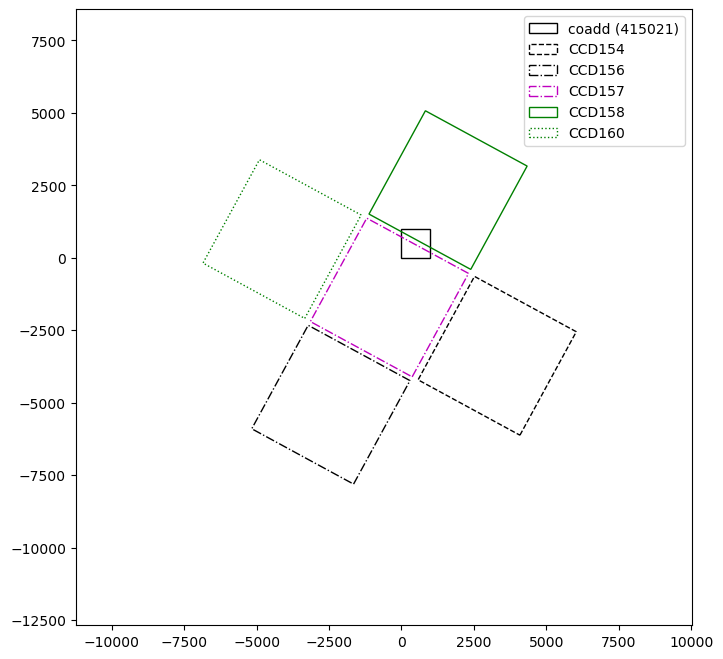

In [34]:
ccdVennDiagram(cutout_coadd, showImage=True, legendLocation='best', vi=visits[25])